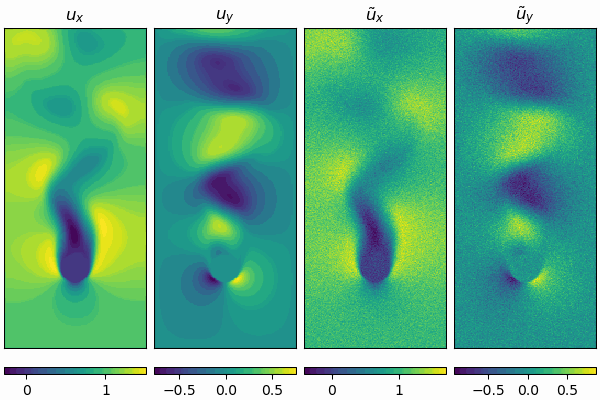

In [1]:
import numpy as np

from src.utils import  load_cylinder_dataset
import os



X_true, X_noisy, simulation_dir = load_cylinder_dataset(noise_type='gauss', 
                                                        noise_level=0.05, 
                                                        smoothing=0.01,
                                                        visualize=True)

Separate the dataset into data to train the POD-ESN and data to test the POD-ESN-EnKF

In [2]:

N_train = 200


X_train, X_train_true = [yy[:N_train].T for yy in [X_noisy, X_true]]
X_filter, X_filter_true = [yy[N_train:].T for yy in [X_noisy, X_true]]



dt = 0.01
t_val = X_train.shape[-1] *.1 * dt 
t_train = X_train.shape[-1] * dt - t_val




# Part I. State estimation


In [36]:
from src.models_datadriven import POD_ESN


case_POD_ESN = POD_ESN(data=X_train,
                       
                   # ====== POD arguments ======== # 
                      domain=[-2, 2, 0, 12],  
                      N_modes=4,  
                     qr_selection = True,
                   # ====== ESN arguments ======== # 
                    t_val=t_val,
                    t_train=t_train,
                    t_test=0.,
                    N_units=40, 
                   train_ESN=True,
                   N_wash=10,
                   noise=0.1,
                   N_func_evals=26,
                   rho_range=[0.2, 0.9],
                   upsample=1,            # NB: I think there is a bug with upsample > 1. I am working on this
                   Nq=2, 
                  
                   # ====== Model arguments ======== # 
                   dt = dt,
                    figs_folder=simulation_dir, 
                    t_CR=0.5
                    )


MODULO (MODal mULtiscale pOd) is a software developed at the von Karman Institute to perform data driven modal decomposition of numerical and experimental data. 

Modulo assumes you have a uniform grid. If not, please give the weights as parameters of MODULO!
Computing correlation matrix...

 Computing Temporal correlation matrix K ...

 Done.
Computing Temporal Basis...
diagonalizing K....
Done.
Computing Spatial Basis...
Computing Phi from D...
Done.
seed 0 	 Optimal hyperparameters: [0.9, 0.1989700043360188], 1e-06, MSE: -2.101928024539592
========= POD-ESN model complete =========


In [37]:
from src.plot_results import plot_truth


def set_truth(case, X_filter, X_filter_true, Nt_obs = 25, visualize=False):
    N_test = X_filter.shape[-1]

    if case.sensor_locations is not None:
        data_obs = X_filter.copy().reshape(-1, N_test)[case.sensor_locations].T
        data_obs_true = X_filter_true.copy().reshape(-1, N_test)[case.sensor_locations].T
    else:
        data_obs = case.project_data_onto_Psi(data=X_filter)
        data_obs_true = case.project_data_onto_Psi(data=X_filter_true)

    dt = case.dt
    t_true = np.arange(0, N_test)  * dt

    t_start = .5
    t_stop = min(5., t_true[-10])
    

    obs_idx = np.arange(t_start // dt, t_stop // dt + 1, Nt_obs, dtype=int) + 1


    # Nt_extra = len(t_true[obs_idx[-1]:])

    _truth = dict(y_raw=data_obs,
                  y_true=data_obs_true, 
                  t=t_true, 
                  dt=dt,
                  t_obs=t_true[obs_idx], 
                  y_obs=data_obs[obs_idx], 
                  dt_obs=Nt_obs * dt,
                  Nt_extra=int(case.t_CR // case.dt),
                  )
    

    if visualize:
        plot_truth(**_truth)
    return _truth

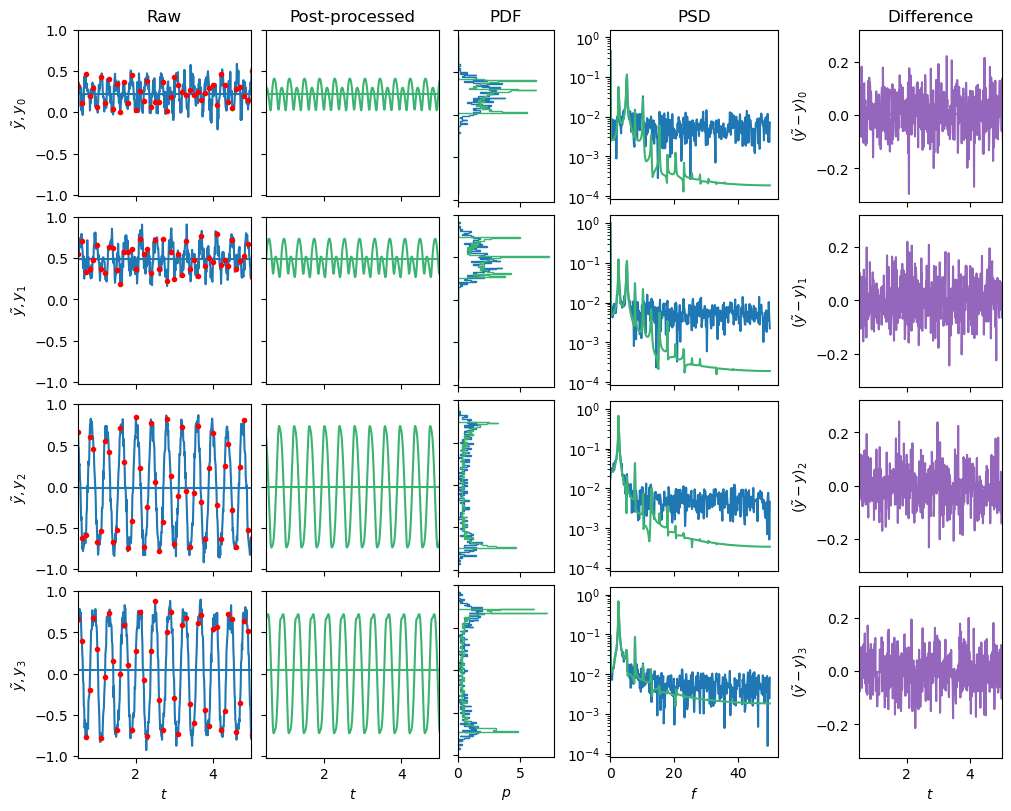

In [38]:

truth = set_truth(case_POD_ESN, 
                  X_filter=X_filter, 
                  X_filter_true=X_filter_true, 
                  Nt_obs=10, 
                  visualize=True
                  )


Define the ensemble 

In [49]:
from src.create import create_ensemble


ensemble = create_ensemble(model=case_POD_ESN,
                           m=10,
                           std_psi=.5)



In [ ]:
from src.post_processing.cylinder import plot_initial_case, view_ensemble

view_ensemble(ensemble)

# This saves a file with plots of the initial case and ensemble (including the fig above)
plot_initial_case(ensemble, X_train, X_train_true,
                  figs_folder=simulation_dir, name='initial_case_state-only') 

In [52]:

from src.data_assimilation import dataAssimilation

ensemble = create_ensemble(model=case_POD_ESN,
                           m=10,
                           std_psi=.1)


# Perform assimilation
filter_ens = dataAssimilation(ensemble=ensemble,
                              std_obs=0.1,
                              y_obs=truth['y_obs'],
                              t_obs=truth['t_obs'],
                              Nt_extra=truth['Nt_extra']
                              )


 ------------------ POD-ESN Model Parameters ------------------ 
	 N_modes = 4
	 N_units = 40
	 N_wash = 10
	 Nq = 4
	 measure_modes = False
	 rho = 0.900000
	 sigma_in = 1.581139
	 update_reservoir = True
	 update_state = True
	 upsample = 1

 ---------------- NoBias bias model input_parameters --------------- 
	 N_ens = 1
	 bayesian_update = False
	 upsample = 1

 -------------------- ASSIMILATION PARAMETERS -------------------- 
 	 Filter = EnKF 
 	 Bias = NoBias 
 	 m = 10 
 	 Time steps between analysis = 9 
 	 Inferred params = [] 
 	 Inflation = 1.002 
 	 Reject Inflation = 1.002 
 	 Ensemble std(psi0) = 0.1
 	 Ensemble std(alpha0) = 0.001
 	 Number of analysis steps = 46, t0=0.5, t1=5.0
Elapsed time to first observation: 0.005585908889770508 s
Assimilation progress: 
	0 % 9% 17% 26% 35% 43% 52% 61% 70% 78% 100% ----------------

Elapsed time during assimilation: 0.08695483207702637 s


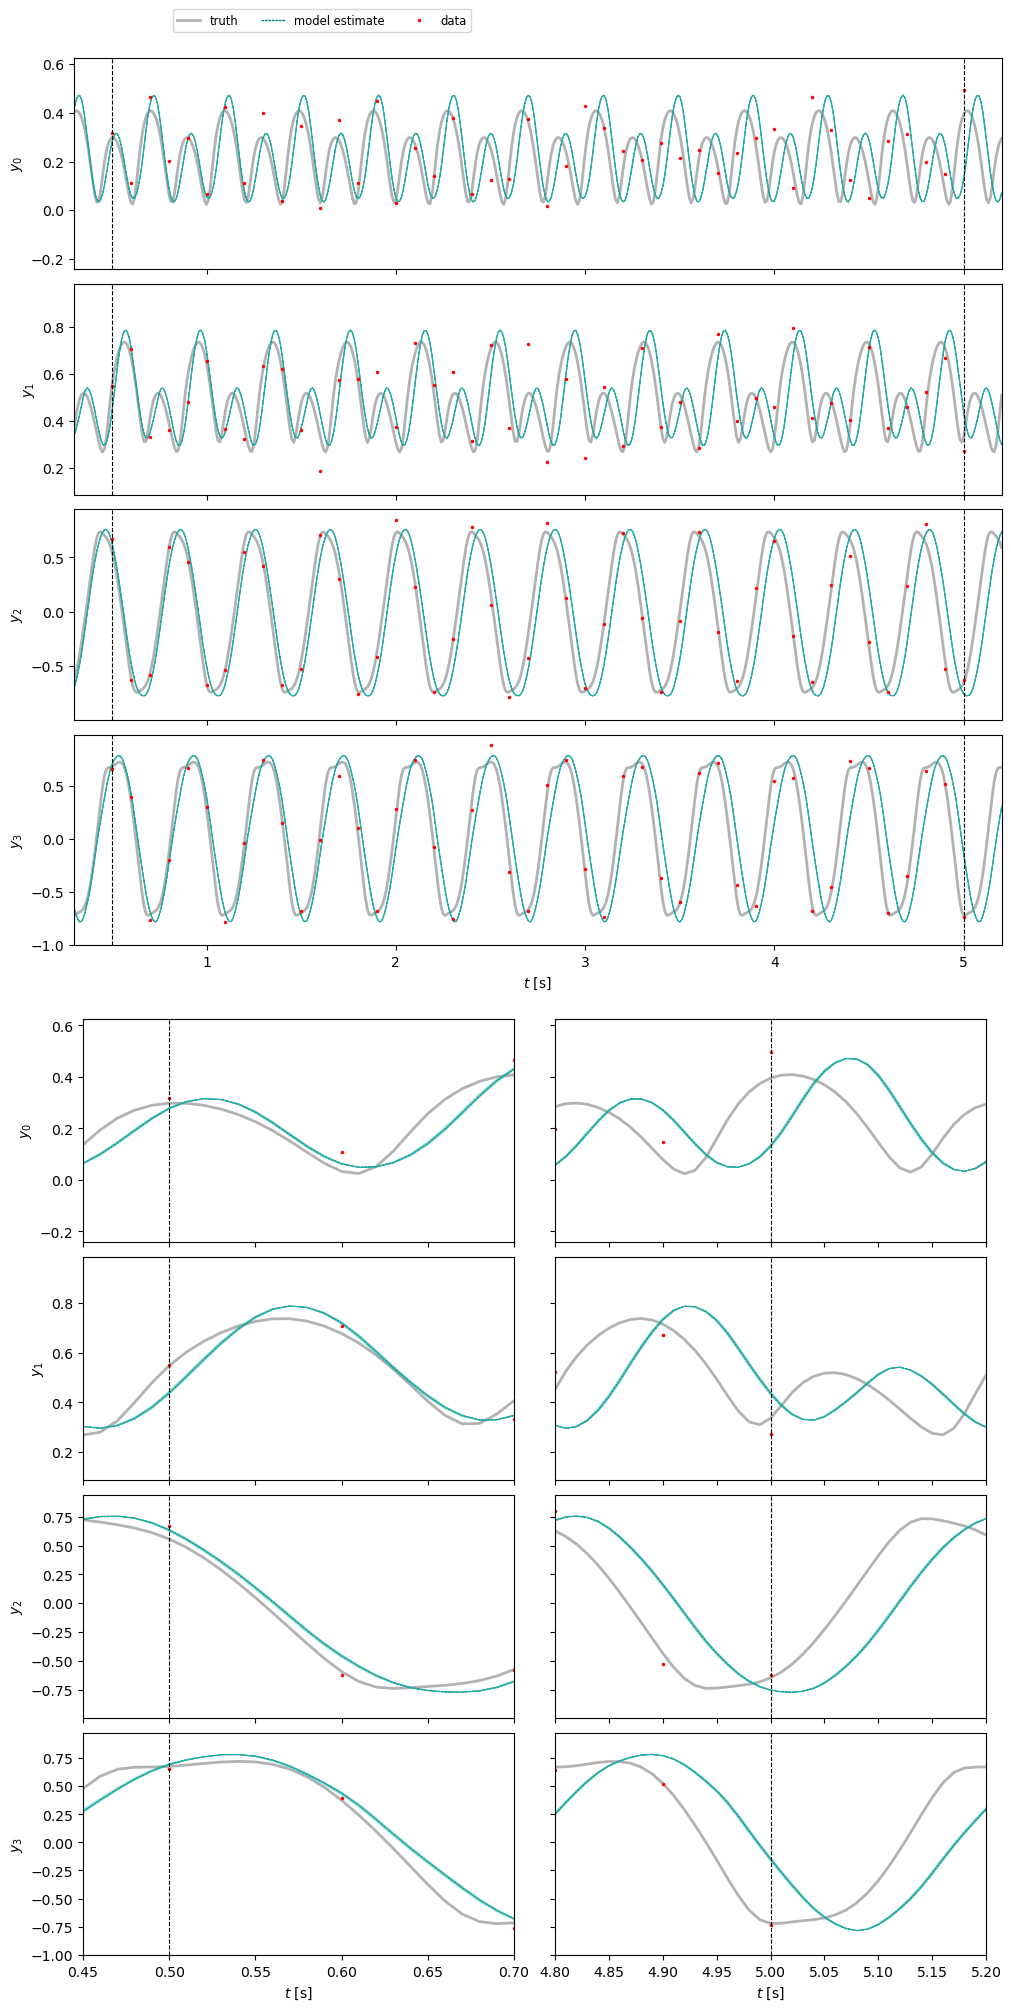

In [53]:


# from src.post_processing.cylinder import plot_timeseries
from src.plot_results import plot_timeseries

plot_timeseries(filter_ens, 
                truth, 
                plot_ensemble_members=1)


# Part II. State & Parameter estimation: online learning of Wout
Why us the SVD interesting in this scenario? Because we can use data assimialtion to modify on the fly the value of the singluar values. This is, we can perform state and parameter inference with the ESN on the fly. In machine learning jargon, this is known as *online learning*.

With this objective, we first need to create an ensemble of POD-ESN with different SVDs for each ensemble member. This is achieved by providing `Wout` as the parameter to estimate, i.e., as the `est_a` argument. The `sta_a` parameter indicates the uncewrtainty around the Wout SVDs.


## Singular value decomposition of Wout
We can decompose the trained Wout into its singular value components using the library ```scipy.linalg```. The multiplication of the three matrices are equivalent to the original Wout. 

Dimensions of matrices: (41, 4) (4,) (4, 4)


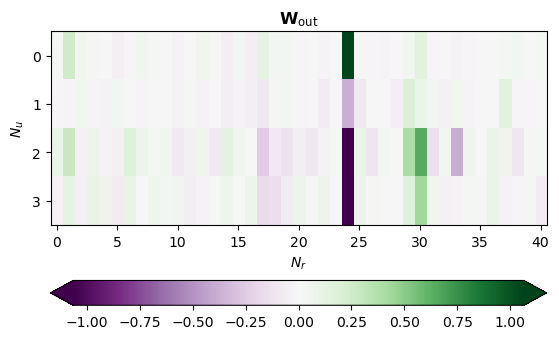

In [54]:
import scipy.linalg as sla
import matplotlib.pyplot as plt
# Compute the SVD of the output matrix
[Wout_U, Wout_eigs, Wout_Vh] = sla.svd(ensemble.Wout, full_matrices=False)


ensemble.plot_Wout()


# # #display the three matrices
# fig, axs = plt.subplots(1, 4, figsize=(15, 15), width_ratios=[1, 1, 1, 1])
# for W, ax, title in zip([ensemble.Wout, Wout_U, np.diag(Wout_eigs), Wout_Vh], axs, 
#                         ['$\\mathbf{W_{out}} = $', '$\\mathbf{U}$', '$\\Sigma$', '$\\mathbf{V}^\\mathrm{T}$']):
#     im = ax.imshow(W, cmap='PuOr', vmin=-np.max(W), vmax=np.max(W))
#     ax.set(title=title)
#     # set the same colorbar for all the matrices
#     fig.colorbar(im, ax=ax, shrink=.9, orientation='horizontal')

print('Dimensions of matrices:', Wout_U.shape, Wout_eigs.shape, Wout_Vh.shape)

assert np.allclose(ensemble.Wout, np.dot(Wout_U, np.dot(np.diag(Wout_eigs), Wout_Vh)))

In [59]:
# Define ensemble
ensemble_2 = create_ensemble( model=case_POD_ESN,
                            filter='EnSRKF', 
                            model_bias=None,
                            m=10,
                            Nt_transient = 500, 
                            std_psi=.1,      
                            est_a=['Wout'], # Estimate the Wout singular values
                            std_a=0.2       # Standard deviation of the noise added to the Wout singular values
                            )



### Wout as SVD
Now the output matrix is decomposed in 3 matrices. the diagonal of the central one is the matrix of singular valuess. these we can modify in time via real-time DA

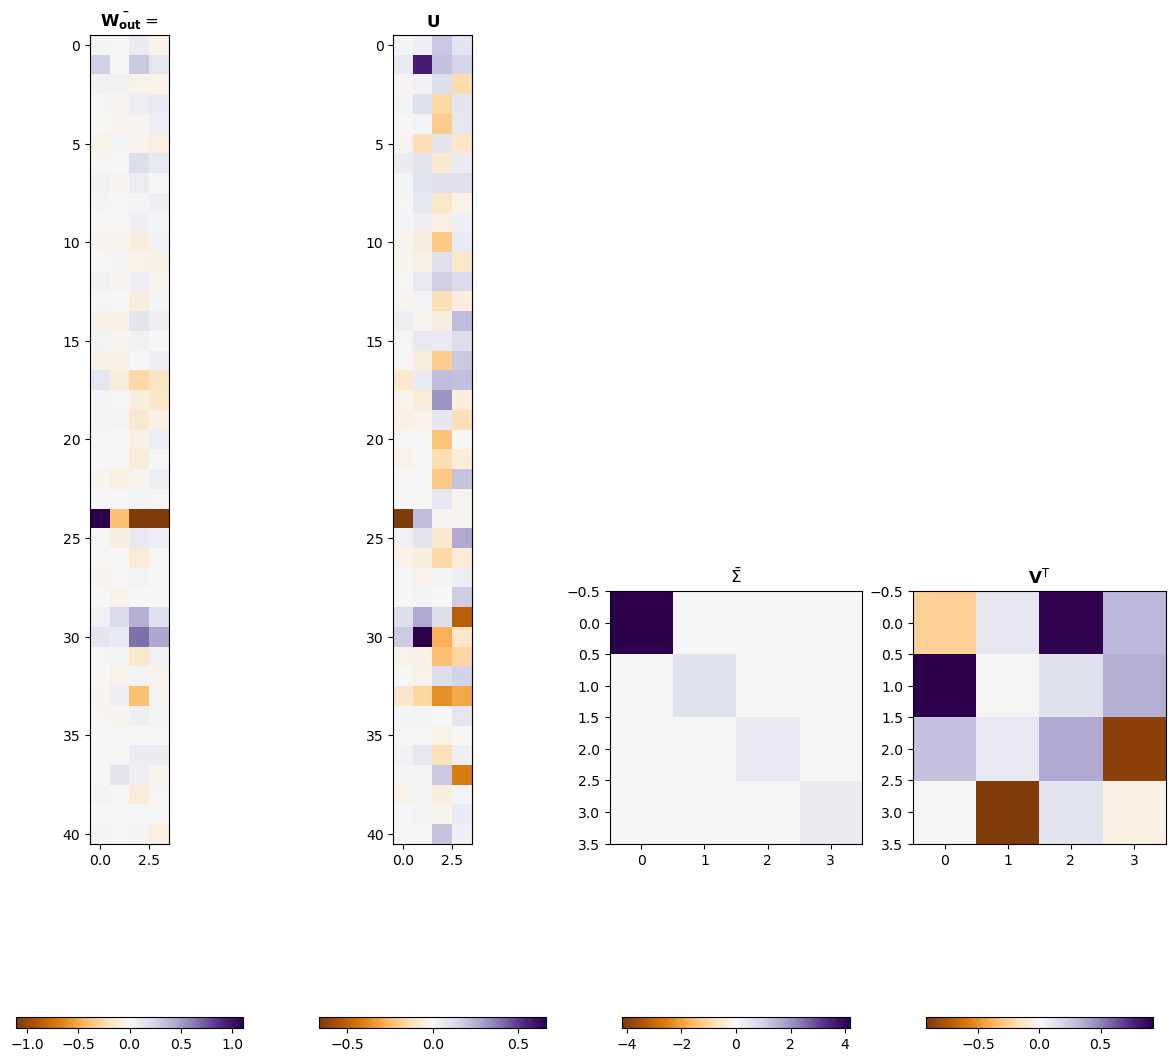

In [60]:

ensemble_2.plot_Wout()  

### Visualize the time evolution of the physical states. 
Uncertainty in the parameters is also shown as increased uncertainty in the states


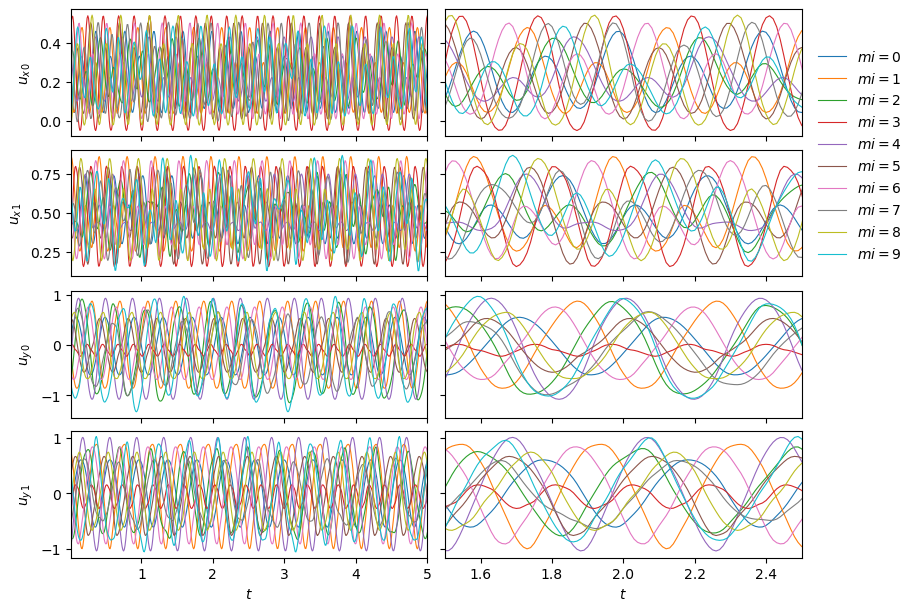

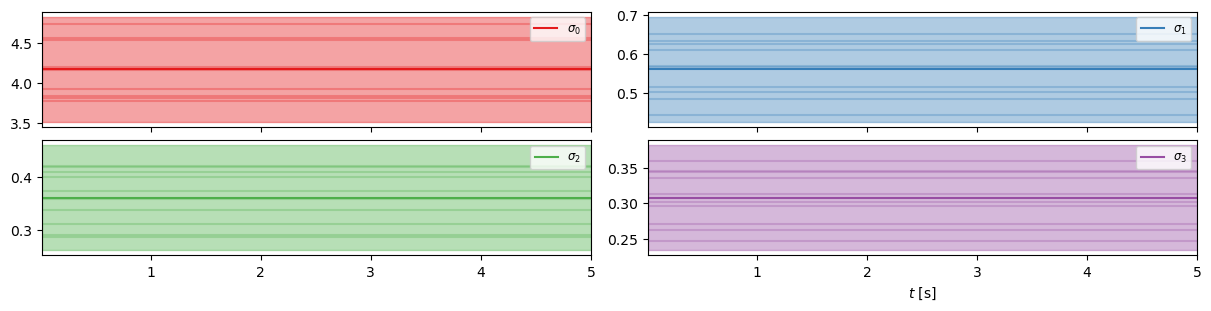

In [61]:


view_ensemble(ensemble_2)